In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import os
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials
import mat73
from neuroformer.SpikeVidUtils import make_intervals, round_n
import seaborn as sns

In [2]:
# pth = "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/ablations_1"
# pth = "./models/tensorboard/visnav_lateral/behavior_pred_exp/classification/ablations_1"
pth = "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/ablations_1"
# get all csvs
files = glob.glob(os.path.join(pth, "**/behavior_pred.csv"), recursive=True)
print(files)

["./models/tensorboard/visnav_medial/behavior_pred_exp/classification/ablations_1/behavior_before_stim_RESUMETrue_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']_finetuning_behavior_0.1/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_pred.csv", "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/ablations_1/finetuning_1.0g/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']/_behavior_predict_no_pretraining_1.0/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_pred.csv", "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/ablations_1/finetuning_0.1g/behavior_before_stim_RESUMETrue_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']/_full_finetuning_2_0.1_full_finetun

In [3]:
from scipy.stats import pearsonr
corrs = dict()
preds = dict()
for f in files:
    behavior_preds = pd.read_csv(f)
    r, p = pearsonr(behavior_preds['behavior'], behavior_preds['true'])
    print(f.split('/')[7])
    print(f"r: {r}, p: {p}")
    behavior_results = pd.DataFrame(columns=['r', 'p'])
    parent_dir = pathlib.Path(f).parent
    behavior_results.to_csv(os.path.join(parent_dir, 'corrs.csv'), index=False)
    corrs[f.split('/')[7]] = r
    preds[f.split('/')[7]] = behavior_preds['behavior'].values

corrs["finetuning_1.0_resumeTrue"] = 0.95
# Add legend inside the plot
rename_mapping = {
    "finetuning_0.01_resumeFalse": "No Pretraining, 1%",
    "finetuning_0.01_resumeTrue": "Finetune, 1%",
    "finetuning_0.1_resumeFalse": "No Pretraining, 10%",
    "finetuning_0.1_resumeTrue": "Finetune, 10%",
    "finetuning_1.0_resumeTrue": "Full Training",
    
}
corrs = {rename_mapping[k]: v for k, v in corrs.items() if k in rename_mapping.keys()}
order = rename_mapping.values()
# reorder according to order
corrs = {k: abs(corrs[k]) for k in order if k in corrs.keys()}

behavior_before_stim_RESUMETrue_paststateTrue_method_behavior_True_['speed']_predictbehaviorTrue_roundedFalsevisualTrue_contrastiveFalse_['id', 'frames', 'behavior_mean']_finetuning_behavior_0.1
r: 0.8259978083222611, p: 0.0
finetuning_1.0g
r: 0.9543719127634008, p: 0.0
finetuning_0.1g
r: 0.05705852256284126, p: 4.329229850956206e-06
finetuning_0.01g
r: 0.14562249732688104, p: 4.934451721296768e-32
finetuning_0.1_resumeNone
r: 0.8791206794103312, p: 0.0
finetuning_0.1_resumeNone
r: 0.029831654711716997, p: 0.016354051645388695
finetuning_0.05_resumeFalse
r: 0.8262765271272164, p: 0.0
finetuning_0.2_resumeTrue
r: 0.8996133720595592, p: 0.0
finetuning_0.2_resumeFalse
r: 0.9121698637996984, p: 0.0
finetuning_0.1_resumeTrue
r: 0.866703293734106, p: 0.0


In [4]:
preds_dict = {
    "Medial": {'Neuroformer': "./results/behavior/Medial/no_pretraining_medial_behavior_pred.csv",
               'MLP': "./results/behavior/Medial/mlp_medial_behavior_pred.csv",
               'GLM': "./results/behavior/Medial/glm_behavior.csv",
               'Lasso Reg.': "./results/behavior/Medial/lasso_behavior.csv"
    },

    "Lateral": {'Neuroformer': "./results/behavior/Lateral/no_pretraining_lateral_behavior_pred.csv",
                'MLP': "./results/behavior/Lateral/mlp_lateral_behavior_pred.csv",
                'GLM': "./results/behavior/Lateral/glm_behavior.csv",
                'Lasso Reg.': "./results/behavior/Lateral/lasso_behavior.csv"
    }
}

color_dict = {
    "Neuroformer": "tab:blue",
    "MLP": "tab:orange",
    "GLM": "tab:purple",
    "Lasso Reg.": "tab:green",
    "True": "tab:red"
}

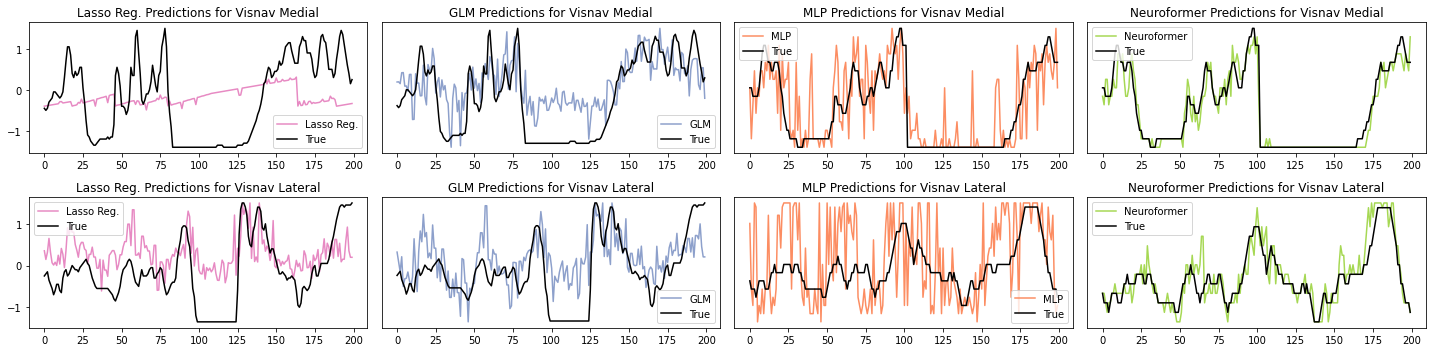

In [5]:
def plot_behavior_predictions(preds_dict, length):
    n_models = max(len(models) for models in preds_dict.values())
    fig, axes = plt.subplots(nrows=len(preds_dict), ncols=n_models, figsize=(20, 5))
    s_tick = 5
  
#     color_dict = {
#     "Neuroformer": "#009E73",  # Strong green
#     "MLP": "#CC79A7",  # Muted pink
#     "GLM": "#56B4E9",  # Sky blue
#     "Lasso Reg.": "#000080",  # Dark blue
#     "True": "#FF7F50"  # Coral
# }

    import seaborn as sns
    color_palette = sns.color_palette("Set2")

    color_dict = {
        "Neuroformer": color_palette[4],  # Light Green
        "MLP": color_palette[1],  # Orange
        "GLM": color_palette[2],  # Light Purple
        "Lasso Reg.": color_palette[3],  # Light Brown
        "True": 'black'  # Teal
    }
#     color_dict = {
#     "Neuroformer": "#264653",  # Japan Blue
#     "MLP": "#e76f51",  # Burnt Sienna
#     "GLM": "#2a9d8f",  # Light Sea Green
#     "Lasso Reg.": "#f4a261",  # Raw Sienna
#     "True": "#E63946"  # Imperial Red
# }
    offset = 25
    # offset_models = ['GLM', 'Lasso Reg.']
    offset_models = ['MLP', 'Neuroformer']
    for j, (dataset, models) in enumerate(preds_dict.items()):
        for i, (model, filepath) in enumerate(reversed(models.items())):
            df = pd.read_csv(filepath)
            # set all values between (-1.5 and 1.5)
            df['behavior'] = df['behavior'].apply(lambda x: max(min(x, 1.5), -1.5))
            df['true'] = df['true'].apply(lambda x: max(min(x, 1.5), -1.5))
            # axes[j, i].scatter(df.index[:length], df['true'][:length], label='True', s=s_tick, color=color_dict['True'])
            # if model in offset_models:
                # offset = 35
            # else:
            offset = 0
            axes[j, i].plot(df['behavior'][offset:length + offset], color=color_dict[model], label=model)
            # axes[j, i].scatter(df.index[:length], df['behavior'][:length], label=model, s=s_tick, color=color_dict[model], marker='x')
            axes[j, i].plot(df['true'][offset:length + offset], color=color_dict['True'], label='True')
            axes[j, i].legend()
            axes[j, i].set_title(f'{model} Predictions for Visnav {dataset}')

            # turn off all y ticks and values except first columns
            if i != 0:
                axes[j, i].set_yticks([])
                axes[j, i].set_yticklabels([])

            
    plt.tight_layout()
    plt.show()



# Plot the first 200 behavior predictions for each CSV file
plot_behavior_predictions(preds_dict, 200)

/tmp/ipykernel_2240909/2876694645.py:24: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x=df['true'][0:length], y=df['behavior'][0:length], kind="hex", gridsize=gridsize, color=color_dict[model], ax=axes[j, i])
/tmp/ipykernel_2240909/2876694645.py:24: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x=df['true'][0:length], y=df['behavior'][0:length], kind="hex", gridsize=gridsize, color=color_dict[model], ax=axes[j, i])
/tmp/ipykernel_2240909/2876694645.py:24: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x=df['true'][0:length], y=df['behavior'][0:length], kind="hex", gridsize=gridsize, color=color_dict[model], ax=axes[j, i])
/tmp/ipykernel_2240909/2876694645.py:24: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  sns.jointplot(x=df['true'][0:length], y=df['behavior'][0:length], kind="hex", gridsize=gridsize, color=color_dict[model], ax=axes[j, i])
/tmp/ipykernel_2

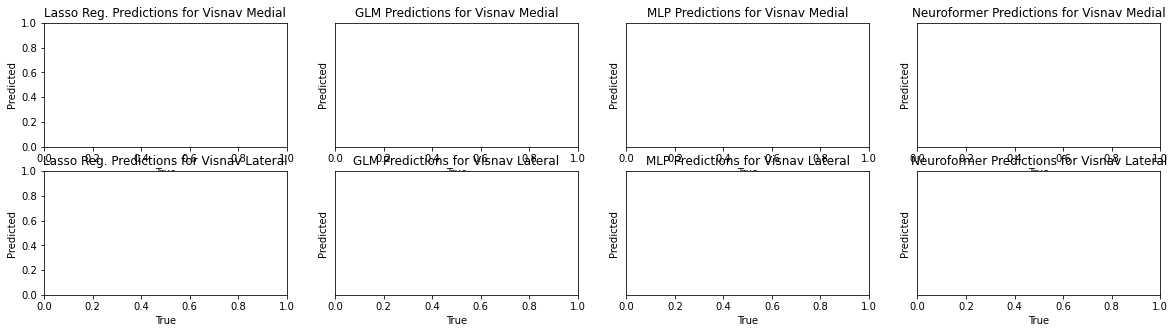

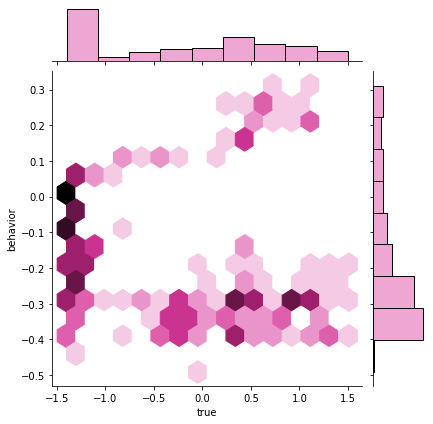

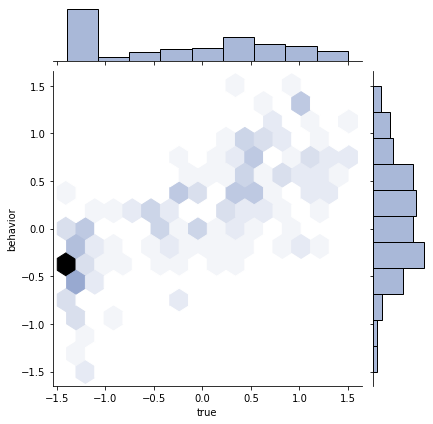

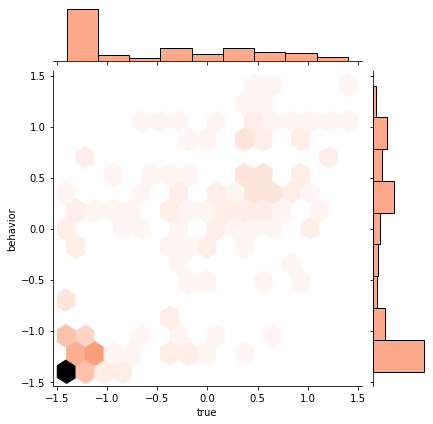

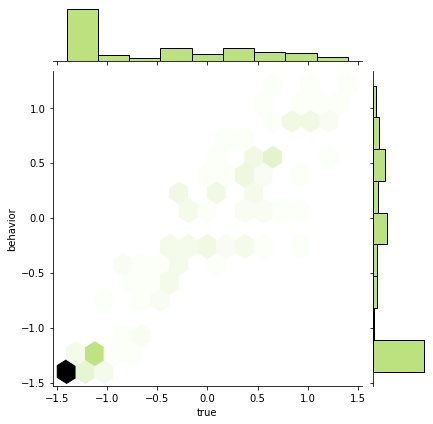

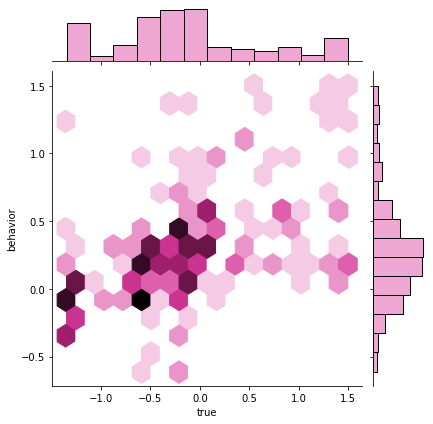

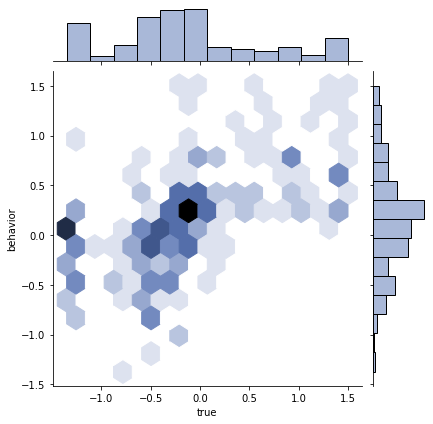

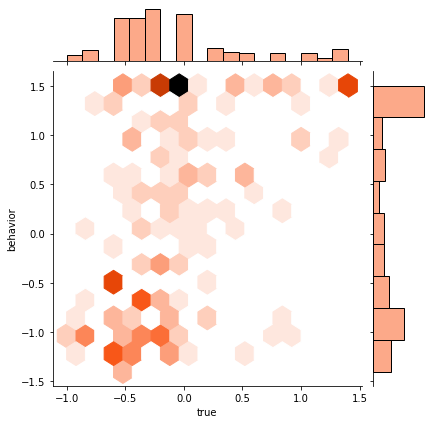

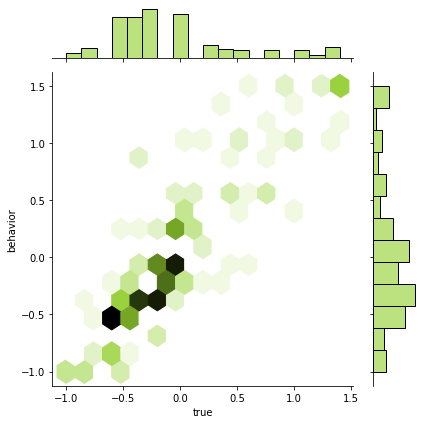

In [6]:
def plot_behavior_predictions_hex(preds_dict, length, gridsize=50):
    import seaborn as sns
    n_models = max(len(models) for models in preds_dict.values())
    fig, axes = plt.subplots(nrows=len(preds_dict), ncols=n_models, figsize=(20, 5))

    color_palette = sns.color_palette("Set2")

    color_dict = {
        "Neuroformer": color_palette[4],  # Light Green
        "MLP": color_palette[1],  # Orange
        "GLM": color_palette[2],  # Light Purple
        "Lasso Reg.": color_palette[3],  # Light Brown
        "True": 'black'  # Teal
    }

    for j, (dataset, models) in enumerate(preds_dict.items()):
        for i, (model, filepath) in enumerate(reversed(models.items())):
            df = pd.read_csv(filepath)
            # set all values between (-1.5 and 1.5)
            df['behavior'] = df['behavior'].apply(lambda x: max(min(x, 1.5), -1.5))
            df['true'] = df['true'].apply(lambda x: max(min(x, 1.5), -1.5))

            # Create a hexplot with a fixed gridsize
            sns.jointplot(x=df['true'][0:length], y=df['behavior'][0:length], kind="hex", gridsize=gridsize, color=color_dict[model], ax=axes[j, i])

            # Set title and labels
            axes[j, i].set_title(f'{model} Predictions for Visnav {dataset}')
            axes[j, i].set_xlabel('True')
            axes[j, i].set_ylabel('Predicted')

            # turn off all y ticks and values except first columns
            if i != 0:
                axes[j, i].set_yticks([])
                axes[j, i].set_yticklabels([])

    plt.tight_layout()
    plt.show()

# Plot the first 200 behavior predictions for each CSV file
plot_behavior_predictions_hex(preds_dict, 200, gridsize=15)

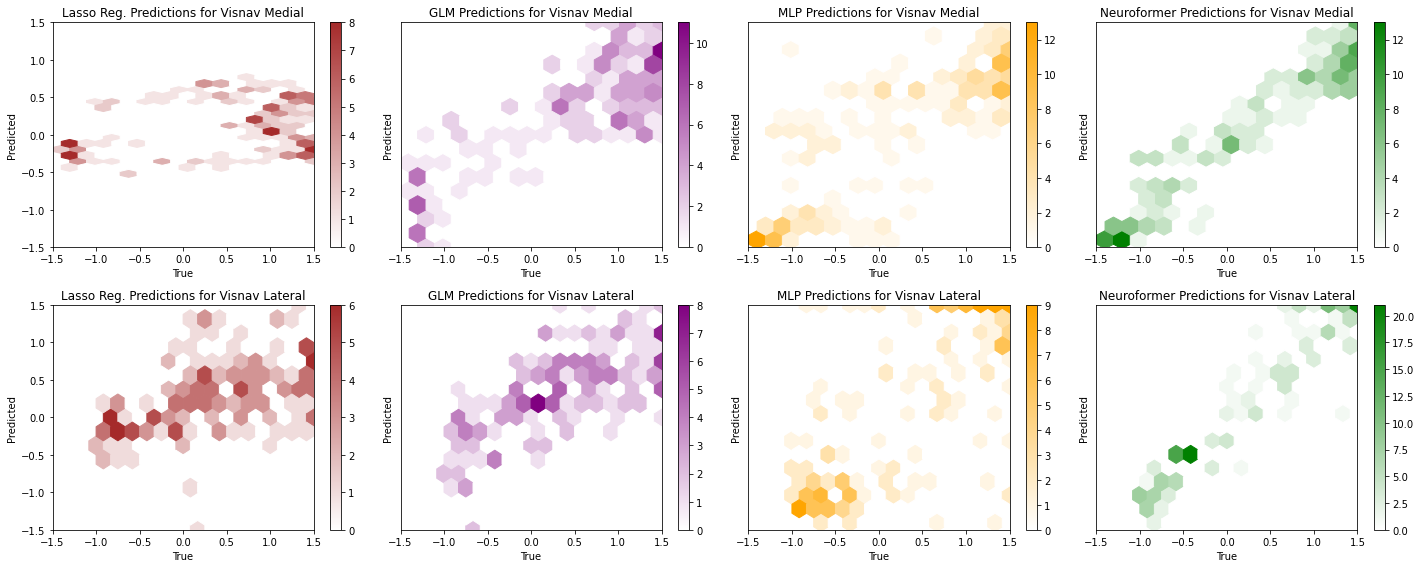

In [21]:
def plot_behavior_predictions_hex(preds_dict, length, gridsize=50):
    n_models = max(len(models) for models in preds_dict.values())
    fig, axes = plt.subplots(nrows=len(preds_dict), ncols=n_models, figsize=(20, 8))

    # Color dictionary
    color_dict = {
        "Neuroformer": 'green',  # Light Green
        "MLP": 'orange',  # Orange
        "GLM": 'purple',  # Light Purple
        "Lasso Reg.": 'brown',  # Light Brown
        "True": 'black'  # Teal
    }
    color_dict = {
        "Neuroformer": 'darkorange',  # Dark Orange
        "MLP": 'midnightblue',  # Midnight Blue
        "GLM": 'gold',  # Gold
        "Lasso Reg.": 'darkblue',  # Dark Blue
        "True": 'black'  # Black
    }
        color_dict = {
        "Neuroformer": 'limegreen',  # Vibrant Green
        "MLP": 'darkorange',  # Dark Orange
        "GLM": 'magenta',  # Magenta (Fuchsia-like)
        "Lasso Reg.": 'darkblue',  # Dark Blue
        "True": 'black'  # Black
    }


    for j, (dataset, models) in enumerate(preds_dict.items()):
        for i, (model, filepath) in enumerate(reversed(models.items())):
            df = pd.read_csv(filepath)
            # set all values between (-1.5 and 1.5)
            df['behavior'] = df['behavior'].apply(lambda x: max(min(x, 1.5), -1.5))
            df['true'] = df['true'].apply(lambda x: max(min(x, 1.5), -1.5))

            n = 7
            
            # Create a colormap that goes from white at the smallest values to model color at the largest
            from matplotlib.colors import LinearSegmentedColormap
            cmap = LinearSegmentedColormap.from_list('my_cmap', ['white', color_dict[model]])

            hb = axes[j, i].hexbin(df['true'][n*length:(n+1)*length], df['behavior'][n*length:(n+1)*length], gridsize=gridsize, cmap=cmap)
            cb = plt.colorbar(hb, ax=axes[j, i])
            # cb.set_label('counts')

            # Set title and labels
            axes[j, i].set_title(f'{model} Predictions for Visnav {dataset}')
            axes[j, i].set_xlabel('True')
            axes[j, i].set_ylabel('Predicted')
            # set x and y limits
            axes[j, i].set_xlim(-1.5, 1.5)
            axes[j, i].set_ylim(-1.5, 1.5)

            # turn off all y ticks and values except first columns
            if i != 0:
                axes[j, i].set_yticks([])
                axes[j, i].set_yticklabels([])
                # axes[j, i].set_xlabel('')

    plt.tight_layout()
    plt.show()


# Plot the first 200 behavior predictions for each CSV file
plot_behavior_predictions_hex(preds_dict, 200, gridsize=15)

In [8]:
# import os
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# import seaborn as sns
# from neuroformer.visualize import nature_style
# # nature_style()
# set_research_params()

# y_keys = ["Loss/test_behavior"]
# y_key_labels = ["Behavior Loss"]
# n_epochs = 100

# # fig.suptitle("Eye pos vs. None, Lateral DS")
# # fig.text(0.5, 0.04, "Epoch", ha="center", va="center")
# # fig.text(0.06, 0.5, "Neural Decoding Loss", ha="center", va="center", rotation=90)

# color_dict = {
#     "Neuroformer": "#009E73",  # Strong green
#     "MLP": "#E69F00",  # Vivid yellow-orange
#     "GLM": "#56B4E9",  # Sky blue
#     "Lasso Reg.": "#CC79A7",  # Muted pink
#     "True": "#FF7F50"  # Coral
# }



# plt.figure(figsize=(1.75, 1.75))
# for n_file, log_file in enumerate(folders):
#         key = log_file.split("/")[7]
#         key_title = rename_mapping[key]
#         for idx, y_key in enumerate(y_keys):
#             event_accumulator = EventAccumulator(log_file)
#             # print(event_accumulator.Tags())
#             event_accumulator.Reload()
#             tags = event_accumulator.Tags()['scalars']
#             if y_key in tags:
#                 values = event_accumulator.Scalars(y_key)
#                 steps = [v.step for v in values][:n_epochs]
#                 values = [v.value for v in values][:n_epochs]
#                 data = pd.DataFrame({"steps": steps, key_title: values})
#                 # sns.lineplot(data=data, x="steps", y=key_title, ax=axs[idx//2, idx%2], label=key_title, color=color_dict[key_title])
#                 plt.plot(steps, values, label=key_title, color=color_dict[key_title])

# plt.legend()
# plt.grid(zorder=0, axis='y', linewidth=0.2)
# plt.xlabel("Epoch")
# plt.ylabel("Behavior Loss (holdout)")

# plt.savefig(os.path.join(save_path, f"losses.pdf"), bbox_inches='tight')
# plt.savefig(os.path.join(save_path, f"losses.png"), bbox_inches='tight')


# # ax.get_legend().remove()
# # make background non-transparent
# # fig.patch.set_alpha(1)
# # plt.tight_layout()

# # save_path = "./models/tensorboard/visnav/behavior_pred_exp/plots"
# plt.savefig(os.path.join(save_path, "losses.png"), dpi=300)
# plt.savefig(os.path.join(save_path, "losses.pdf"), dpi=300)